# Combining Solar Panels

This study explores the effect of variability in exposure and panel characteristics of PV panels in an array on the array's yield.




### Setup

Import neccessary packages.  Setup constants and panel parameters.

In [37]:
from pvlib import pvsystem, singlediode, ivtools
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.constants import e as qe, k as kB

# For simplicity, use cell temperature of 25C for all calculations.
# kB is J/K, qe is C=J/V
# kB * T / qe -> V
Vth = kB * (273.15+25) / qe

# Input the module parameters from the datasheet
# Panasonic N330
module_parameters = {
    'celltype': 'monoSi',
    'V_mp_ref': 58.0,
    'I_mp_ref': 5.7,
    'V_oc_ref': 69.7,
    'I_sc_ref': 6.07,
    'alpha_sc': 0.00334,
    'beta_oc': -0.16,
    'gamma_pmp': -0.258,
    'cells_in_series': 96,  # data sheet shows 96 cells and states 4 bypass diodes
    'temp_ref': 25
}

# convert the module parameters to cell parameters
cell_parameters = {
    'celltype': 'monoSi',
    'V_mp_ref': module_parameters['V_mp_ref'] / module_parameters['cells_in_series'],
    'I_mp_ref': module_parameters['I_mp_ref'], #would not change
    'V_oc_ref': module_parameters['V_oc_ref'] / module_parameters['cells_in_series'],
    'I_sc_ref': module_parameters['I_sc_ref'],
    'alpha_sc': 0.00334,
    'beta_oc': module_parameters['beta_oc'] / module_parameters['cells_in_series'],
    'gamma_pmp': -0.258,
    'temp_ref': 25,
    'breakdown_factor': 2e-3,
    'breakdown_exp': 3,
    'breakdown_voltage': -15,
}

#looking into how to treat series and shunt resistance going from module to cell

# Use ivtools to estimate parameters for the CEC SDM
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = ivtools.sdm.fit_cec_sam(module_parameters['celltype'], 
                                                                         module_parameters['V_mp_ref'], 
                                                                         module_parameters['I_mp_ref'], 
                                                                         module_parameters['V_oc_ref'], 
                                                                         module_parameters['I_sc_ref'], 
                                                                         module_parameters['alpha_sc'], 
                                                                         module_parameters['beta_oc'], 
                                                                         module_parameters['gamma_pmp'], 
                                                                         module_parameters['cells_in_series'], 
                                                                         module_parameters['temp_ref'])

# Add these new estimated parameters
module_parameters['I_L_ref']=I_L_ref
module_parameters['I_o_ref']=I_o_ref
module_parameters['R_s']=R_s
module_parameters['R_sh_ref']=R_sh_ref
module_parameters['a_ref']=a_ref

print('Rsh_module=',module_parameters['R_sh_ref'])
print('Rs_module=',module_parameters['R_s'])

# add these new estimated parameters to the cell parameters
cell_parameters['I_L_ref']=I_L_ref
cell_parameters['I_o_ref']=I_o_ref
cell_parameters['R_s']=R_s/module_parameters['cells_in_series']
cell_parameters['R_sh_ref']=R_sh_ref/module_parameters['cells_in_series']
cell_parameters['a_ref']=a_ref/module_parameters['cells_in_series']

print('Rsh_cell=',cell_parameters['R_sh_ref'])
print('Rs_cell=',cell_parameters['R_s'])

# Full sun
Geff_full=1000

# Shaded
Geff_shade=100


Rsh_module= 457.49579164575226
Rs_module= 0.7372538415650246
Rsh_cell= 4.765581162976586
Rs_cell= 0.007679727516302339


Use De Soto simulate an IV curve.

(0.0, 25.0)

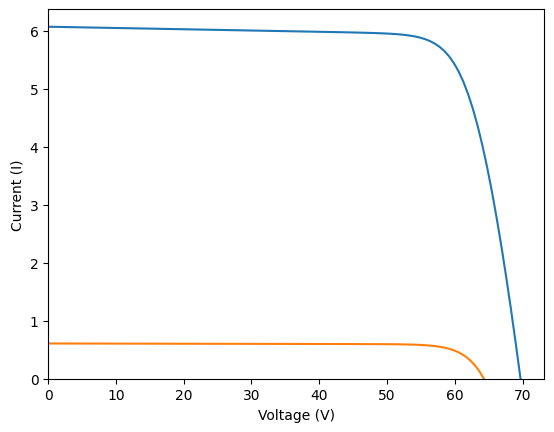

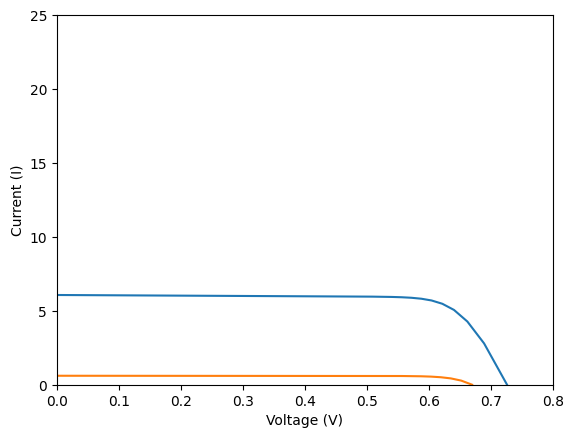

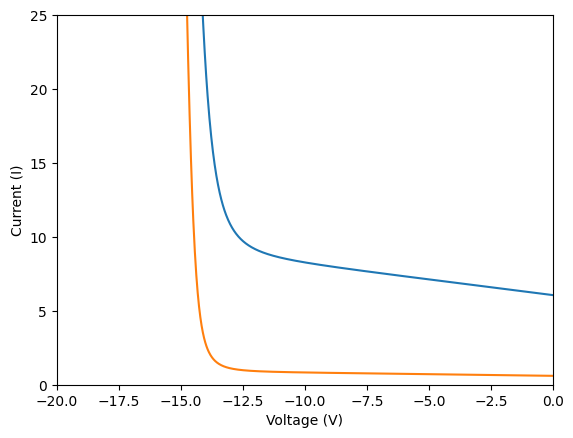

In [38]:

def simulate_full_curve(parameters, Geff, Tcell, ivcurve_pnts=1000):
    """
    Use De Soto to simulate a full IV curve.
    """
    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
        Geff,
        Tcell,
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
    )

    SDE_params = {
        'photocurrent': IL,
        'saturation_current': I0,
        'resistance_series': Rs,
        'resistance_shunt': Rsh,
        'nNsVth': nNsVth
    }

    # Use the SDE parameters to calculate points on the IV curve
    
    curve_info = pvsystem.singlediode(method='lambertw', **SDE_params)
    v_curve = pd.DataFrame({'v': np.linspace(0, curve_info['v_oc'], 100)})
    i_curve = pd.DataFrame({'i': pvsystem.i_from_v(voltage=v_curve['v'], method='lambertw', **SDE_params)})

    return pd.DataFrame({
    'i': i_curve['i'],
    'v': v_curve['v'],
    })

def simulate_cell_full_curve(parameters, Geff, Tcell, ivcurve_pnts=1000):
    """
    Use De Soto and Bishop to simulate a full IV curve with both
    forward and reverse bias regions.
    """
    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    sde_args = pvsystem.calcparams_desoto(
        Geff,
        Tcell,
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
    )
    # sde_args has values:
    # (photocurrent, saturation_current, resistance_series,
    # resistance_shunt, nNsVth)

    # Use Bishop's method to calculate points on the IV curve with V ranging
    # from the reverse breakdown voltage to open circuit
    kwargs = {
        'breakdown_factor': parameters['breakdown_factor'],
        'breakdown_exp': parameters['breakdown_exp'],
        'breakdown_voltage': parameters['breakdown_voltage'],
    }
    v_oc = singlediode.bishop88_v_from_i(
        0.0, *sde_args, **kwargs
    )
    # ideally would use some intelligent log-spacing to concentrate points
    # around the forward- and reverse-bias knees, but this is good enough:
    vd = np.linspace(0.99*kwargs['breakdown_voltage'], v_oc, ivcurve_pnts)

    ivcurve_i, ivcurve_v, _ = singlediode.bishop88(vd, *sde_args, **kwargs)
    return pd.DataFrame({
        'i': ivcurve_i,
        'v': ivcurve_v,
    })

def interpolate(df, i):
    """convenience wrapper around scipy.interpolate.interp1d"""
    f_interp = interp1d(np.flipud(df['i']), np.flipud(df['v']), kind='linear',
                        fill_value='extrapolate')
    return f_interp(i)


def combine_series(dfs):
    """
    Combine IV curves in series by aligning currents and summing voltages.
    The current range is based on the first curve's current range.
    """
    df1 = dfs[0]
    imin = df1['i'].min()
    imax = df1['i'].max()
    i = np.linspace(imin, imax, 1000)
    v = 0
    for df2 in dfs:
        v_cell = interpolate(df2, i)
        v += v_cell
    return pd.DataFrame({'i': i, 'v': v})

# create a curve and plot (test)
curve_full = simulate_full_curve(module_parameters, Geff_full, 25)
curve_shade = simulate_full_curve(module_parameters, Geff_shade, 25)
plt.plot(curve_full['v'], curve_full['i'])
plt.plot(curve_shade['v'], curve_shade['i'])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (I)')
plt.xlim(left=0)  # Set the left limit of the x-axis to 0
plt.ylim(bottom=0)  # Set the bottom limit of the y-axis to 0

# create a curve and plot for cells (test)

curve_full = simulate_cell_full_curve(cell_parameters, Geff_full, 25)
curve_shade = simulate_cell_full_curve(cell_parameters, Geff_shade, 25)
plt.figure()
plt.plot(curve_full['v'], curve_full['i'])
plt.plot(curve_shade['v'], curve_shade['i'])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (I)')
plt.xlim(left=0)  # Set the left limit of the x-axis to 0
plt.xlim(right=0.8)  # Set the right limit of the x-axis to 0.7
plt.ylim(bottom=0)  # Set the bottom limit of the y-axis to 0
plt.ylim(top=25)  # Set the top limit of the y-axis to 0.1

plt.figure()
plt.plot(curve_full['v'], curve_full['i'])
plt.plot(curve_shade['v'], curve_shade['i'])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (I)')
plt.xlim(left=-20)  # Set the left limit of the x-axis to 0
plt.xlim(right=0)  # Set the right limit of the x-axis to 0.7
plt.ylim(bottom=0)  # Set the bottom limit of the y-axis to 0
plt.ylim(top=25)  # Set the top limit of the y-axis to 0.1
#plt.savefig('test.png')


## Uniform Case (Control)
### 2S2P
### 4P


## Uniform Case (Control)
### Series
### Parallel
### Dedicated MPPT

## Variation In Exposure Angle
### Series
### Parallel
### Dedicated MPPT

## Variation in Shading
### Series
### Parallel
### Dedicated MPPT

## Variation in Panel Make/Model
### Series
### Parallel
### Dedicated MPPT